In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

In [2]:
from sqlalchemy import create_engine


driver = 'mysql+pymysql:'
user = 'adria'
password = '00000'
ip = '35.187.114.125'
database = 'vimet'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [3]:
orders = pd.read_sql('orders', con = engine)

In [4]:
orders.head()

index   Name  Customer Financial Status Fulfillment Status  Total  \
0      0  #1247         1             paid          fulfilled   63.9   
1      1  #1246         2             paid        unfulfilled   94.0   
2      2  #1245         3             paid          fulfilled   37.4   
3      3  #1244         4             paid          fulfilled   49.9   
4      4  #1243         5             paid          fulfilled   45.0   

   Discount Amount Shipping Method Shipping Zip Payment Method  \
0              0.0          shargo        08041         Stripe   
1              0.0        gratuito        08003         Stripe   
2              0.0          shargo        08006         Stripe   
3              0.0          shargo        08032         Stripe   
4              0.0          shargo        08021         Stripe   

   Refunded Amount  Discount Code Notes  
0              0.0              0  None  
1              0.0              0  None  
2              0.0              0  None  
3              0.0              0  None  
4              0.0              0  None

We have mainly 3 numeric fields in orders. All of them refer to prices and refunds.

## Numerical features

In [5]:
orders.describe()[['Total', 'Discount Amount', 'Refunded Amount']]

Total  Discount Amount  Refunded Amount
count  220.000000       220.000000       220.000000
mean    66.495182         1.181818         2.026136
std     43.542480         3.323314         6.155890
min      2.850000         0.000000         0.000000
25%     41.997500         0.000000         0.000000
50%     61.800000         0.000000         0.000000
75%     79.225000         0.000000         0.000000
max    344.450000        32.400000        45.400000

In [6]:
print(f"The total invoiced is {round(sum(orders['Total']),2)} €")
print (f"The total discounts is {round(sum(orders['Discount Amount']),2)} €")
print (f"The total refunds is {round(sum(orders['Refunded Amount']),2)} €")

The total invoiced is 14628.94 €
The total discounts is 260.0 €
The total refunds is 445.75 €


We will check if there is any correlation between 'Discount Amount' and the 'Total' amount spent.

### Total

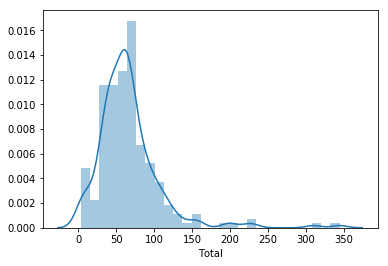

In [7]:
sns.distplot(orders['Total'])
plt.show()

### Discount amount

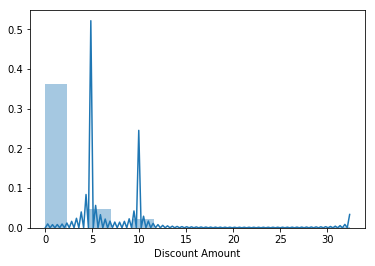

In [8]:
sns.distplot(orders['Discount Amount'])
plt.show()

We can see that there are very limited possible values for a discount:

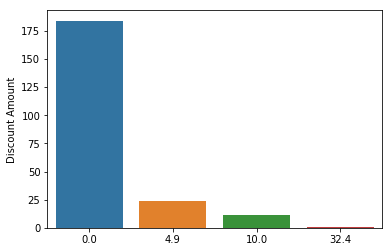

In [9]:
sns.barplot(x=orders['Discount Amount'].value_counts().index, y= orders['Discount Amount'].value_counts())
plt.show()

We can see that the most common discount (if any) is 4.9 EUR which corresponds to 'free shipping'.

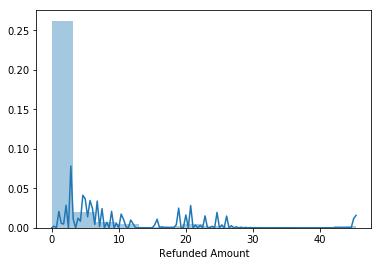

In [10]:
sns.distplot(orders['Refunded Amount'])
plt.show()

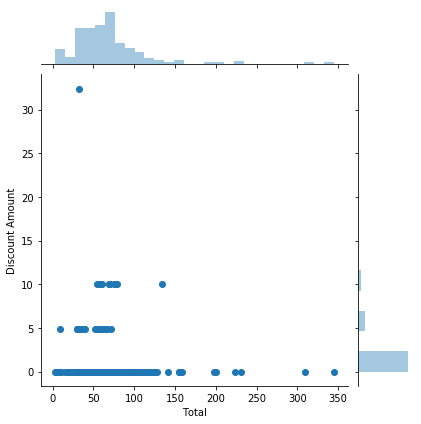

In [11]:
sns.jointplot(x=orders['Total'],y=orders['Discount Amount'])
plt.show()

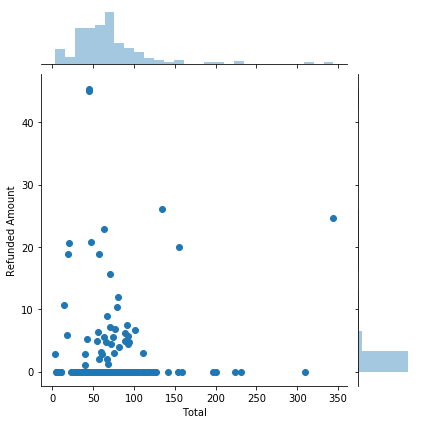

In [12]:
sns.jointplot(x=orders['Total'],y=orders['Refunded Amount'])
plt.show()

There is no correlation observed between the discounts and the total amount spent. Additionally, the refunds have'nt any relation either.

## Cathegorical features

In [13]:
orders.head()

index   Name  Customer Financial Status Fulfillment Status  Total  \
0      0  #1247         1             paid          fulfilled   63.9   
1      1  #1246         2             paid        unfulfilled   94.0   
2      2  #1245         3             paid          fulfilled   37.4   
3      3  #1244         4             paid          fulfilled   49.9   
4      4  #1243         5             paid          fulfilled   45.0   

   Discount Amount Shipping Method Shipping Zip Payment Method  \
0              0.0          shargo        08041         Stripe   
1              0.0        gratuito        08003         Stripe   
2              0.0          shargo        08006         Stripe   
3              0.0          shargo        08032         Stripe   
4              0.0          shargo        08021         Stripe   

   Refunded Amount  Discount Code Notes  
0              0.0              0  None  
1              0.0              0  None  
2              0.0              0  None  
3              0.0              0  None  
4              0.0              0  None

## Financial status

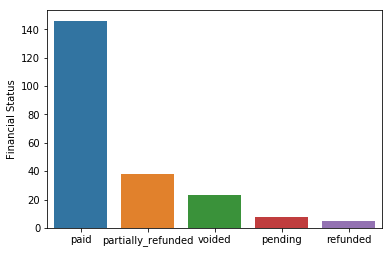

In [14]:
sns.barplot(x=orders['Financial Status'].value_counts().index, y = orders['Financial Status'].value_counts())
plt.show()

## Fulfillment status

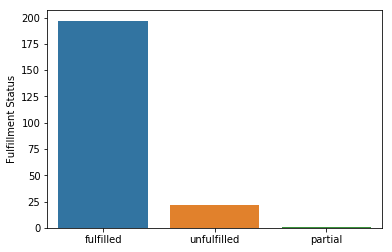

In [15]:
sns.barplot(x= orders['Fulfillment Status'].value_counts().index, y=orders['Fulfillment Status'].value_counts())
plt.show()

## Shipping method

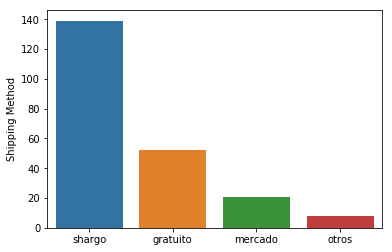

In [16]:
sns.barplot(x=orders['Shipping Method'].value_counts().index, y=orders['Shipping Method'].value_counts())
plt.show()

## Location of the deliveries

In [17]:
# We create a new dataframe to be able to access the frequency of each zip code.
orders_per_zip = orders['Shipping Zip'].value_counts().reset_index()

In [18]:
# We create a dictionary with the approximate coordinates of each zip code to be able to build a map.

zip_coord = {'08021': (41.397834, 2.139866), '08006':(41.399802, 2.148402), '08034': (41.394100, 2.112257), 
 '08017': (41.416779, 2.099958), '08041': (41.418612, 2.176570), '08023': (41.413024, 2.142874),
 '08012': (41.402486, 2.155635), '08005': (41.398042, 2.200548), '08037': (41.399330, 2.165179),
 '08008': (41.395246, 2.159904), '08009': (41.394974, 2.170825), '08029': (41.389274, 2.141904),
 '08036': (41.389867, 2.150552), '08032': (41.423789, 2.161454), '08018': (41.403284, 2.191562),
 '08028': (41.379177, 2.127690), '08024': (41.412017, 2.157952), '08022': (41.409829, 2.132717),
 '08980': (41.399206, 2.052781), '08193': (41.496427, 2.089686), '08003': (41.384383, 2.184302)}

In [19]:
# We create a map using the dictionary for the coordinates and the post code, which will be the popup text but also
# will be used to find the frequency of such code in the dataframe. Such frequency will define the radius.
import folium
latlon = list(zip_coord.items())
m = folium.Map(location=[41.397834, 2.139866], tiles='Stamen Toner', zoom_start=13)
for code, coord in zip_coord.items():
    folium.CircleMarker(location=list(coord), 
                        radius=int(orders_per_zip[orders_per_zip['index']==code]['Shipping Zip']), 
                        popup=code, color='#3186cc', fill=True, 
                        fill_color='#3186cc').add_to(m)

In [20]:
m

In [21]:
m.save('map.html')

We can see that most of the deliveries are concetrated in one are in Barcelona.

## Payment method

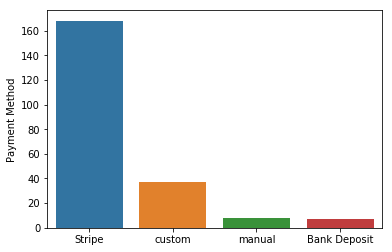

In [22]:
sns.barplot(x = orders['Payment Method'].value_counts().index, y =orders['Payment Method'].value_counts())
plt.show()

## Discount code

In [23]:
orders.head()

index   Name  Customer Financial Status Fulfillment Status  Total  \
0      0  #1247         1             paid          fulfilled   63.9   
1      1  #1246         2             paid        unfulfilled   94.0   
2      2  #1245         3             paid          fulfilled   37.4   
3      3  #1244         4             paid          fulfilled   49.9   
4      4  #1243         5             paid          fulfilled   45.0   

   Discount Amount Shipping Method Shipping Zip Payment Method  \
0              0.0          shargo        08041         Stripe   
1              0.0        gratuito        08003         Stripe   
2              0.0          shargo        08006         Stripe   
3              0.0          shargo        08032         Stripe   
4              0.0          shargo        08021         Stripe   

   Refunded Amount  Discount Code Notes  
0              0.0              0  None  
1              0.0              0  None  
2              0.0              0  None  
3              0.0              0  None  
4              0.0              0  None

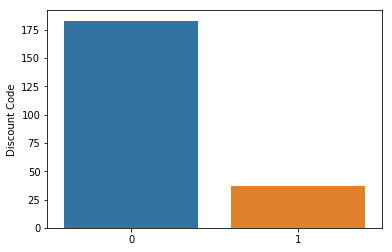

In [24]:
sns.barplot( x= orders['Discount Code'].value_counts().index, y=orders['Discount Code'].value_counts())
plt.show()

We will not analyse the notes for now.